# Курсой проект для курса "Python для Data Science"  
***
## Прогноз цен на недвижимость

**Материалы к проекту (файлы):**  
train.csv  
test.csv

**Задание:**  
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).  
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

**Целевая переменная:**  
Price

**Метрика качества:**  
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

**Требования к решению:**  
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb/
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

**Рекомендации для файла с кодом (ipynb):**  
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию, но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.  
11. Прогнозирование на тестовом датасете:  
    11.1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков (лучше выполнять действия сразу для двух датасетов).  
    11.2. Не потерять и не перемешать индексы от примеров при построении прогнозов.  
    11.3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк).  
12. Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

**Описание датасета**:  
- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
- **Social_1, Social_2, Social_3** - социальные показатели местности
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры

***

## (1) Подключение библиотек, общие настройки, создание функций

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'svg'
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    Функция оценивает точность модели 3 метриками: R2, MAE, и MSE.
    
    Функция принимает 4 array-like параметра:
    
    - правильные значения, в т.ч.:
        > train_true_values - из тренировочной выборки;
        > test_true_values - из тестовой выборки.
    
    - предсказанные моделью значения, в т.ч.:
        > train_pred_values - из тренировочной выборки;
        > test_pred_values - из тестовой выборки.
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

## (2) Загрузка исходных данных

In [3]:
# прописываем пути до исходных и результирующих файлов
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
RESULT_PATH = 'AManzhetov_predictions.csv'

In [4]:
# загружаем исходные файлы в pandas.DataFrame
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [5]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [7]:
# сделаем общую базу для рассчета максимально точных коэффициентов без учета цены (целевой переменной)
df = pd.concat([df_train, df_test], axis=0)

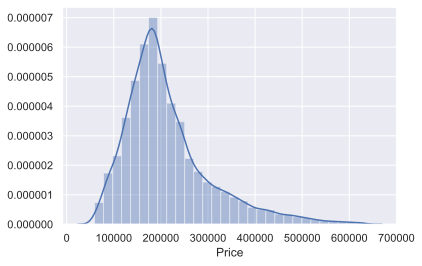

In [8]:
sns.distplot(df_train['Price'], bins=30) # выбросов не видно в целевой переменной

## (3) Подготовка и очистка данных

In [9]:
df_train.dtypes, df_test.dtypes

(Id                 int64
 DistrictId         int64
 Rooms            float64
 Square           float64
 LifeSquare       float64
 KitchenSquare    float64
 Floor              int64
 HouseFloor       float64
 HouseYear          int64
 Ecology_1        float64
 Ecology_2         object
 Ecology_3         object
 Social_1           int64
 Social_2           int64
 Social_3           int64
 Healthcare_1     float64
 Helthcare_2        int64
 Shops_1            int64
 Shops_2           object
 Price            float64
 dtype: object,
 Id                 int64
 DistrictId         int64
 Rooms            float64
 Square           float64
 LifeSquare       float64
 KitchenSquare    float64
 Floor              int64
 HouseFloor       float64
 HouseYear          int64
 Ecology_1        float64
 Ecology_2         object
 Ecology_3         object
 Social_1           int64
 Social_2           int64
 Social_3           int64
 Healthcare_1     float64
 Helthcare_2        int64
 Shops_1            in

In [10]:
# убираем id из числовых признаков
df_train['Id'] = df_train['Id'].astype(str)
df_test['Id'] = df_test['Id'].astype(str)

In [11]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [12]:
df_test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


### Анализ данных
**Из описания данных можно отметить следующие проблемы и варианты их решения:**  
- имеют место **выбросы** по следующим полям:
    - *Square, LifeSquare, KitchenSquare* (значение 0 или слишком большое значение) -- выбросы можно заполнить по коэффициентом отношения соответствующей площади к общей площади;
    - *Rooms* (0 комнат быть не может, в 17/19 сложно поверить при таких ценах `df_train.loc[df_train['Rooms'] > 10, :]`) -- выбросы можно заполнить по коэффициентам отношения жилой площади к количеству комнат;
    - *HouseFloor, Floor, HouseYear* (неправдоподобные значения) -- можно ограничить максимум и минимум;
- признаки *Healthcare_1 и LifeSquare* содержат **неполные данные**:
    - *Healthcare_1* можно взять среднее по *District* -- это похоже на правду и не исказит данные;
    - отсутствующие *LifeSquare* лучше всего рассчитать по соотношению жилых и общих площадей по заполненным данным;
- **категориальные переменные** *Shops_2, Ecology_2 и Ecology_3* перевисти в числовые переменные.

### (3.1) Обработка выбросов

имеют место выбросы по следующим полям:

    - Rooms (0 комнат быть не может, в 17/19 сложно поверить при таких ценах df_train.loc[df_train['Rooms'] > 10, :]) -- выбросы можно заполнить по коэффициентам отношения жилой площади к количеству комнат;
    - Square, LifeSquare, KitchenSquare (значение 0 или слишком большое значение) -- выбросы можно заполнить по коэффициентом отношения соответствующей площади к общей площади;
    - HouseFloor, Floor, HouseYear (неправдоподобные значения) -- можно ограничить максимум и минимум;


**Square**

In [13]:
# смотрим примерный состав общей площади по общему датасету
df['Square'].sort_values()

6392      1.136859
66        1.378543
4902      1.975769
8283      1.988943
4490      2.372101
           ...    
3217    223.453689
1982    275.645284
4690    409.425181
4262    604.705972
6977    641.065193
Name: Square, Length: 15000, dtype: float64

In [14]:
# смотрим большИе квартиры
df.loc[df['Square'] > 300]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562


In [15]:
# данные явно битые -> удаляем из train (price в df проставлен => эта проблема только в тренировочном датасете)
df_train = df_train.drop(df_train.loc[df_train['Square'] > 300].index)
df = df.drop(df.loc[df['Square'] > 300].index)

In [16]:
# малая площадь явно ошибочна и ее нужно рассчитать на основе жилой площади (после заполнения неполных данных)
df.loc[(df['Square'] < 20) & (df['Rooms'] > 1) & (df['Square'] >= df['LifeSquare'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


Случаи, когда жилая площадь превышает общую площадь следует обсчитать после заполнения всех значений жилой площади в п.(3.2)

**LifeSquare**

In [17]:
# смотрим примерный состав жилой площади по общему датасету
df.loc[(df['LifeSquare'] < df['Square']) & (df['LifeSquare'] < 10), 'LifeSquare'].dropna().sort_values()

78      0.333490
6609    0.370619
2992    0.567267
26      0.641822
9602    0.795539
          ...   
3554    5.954610
5398    5.996579
7767    8.822988
3697    9.495367
1195    9.698766
Name: LifeSquare, Length: 306, dtype: float64

In [18]:
df.loc[(df['LifeSquare'] < df['Square']) & (df['LifeSquare'] < 10)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
95,4280,34,2.0,61.334968,4.091945,1.0,26,1.0,2014,0.069753,B,B,53,13670,4,NaN,1,11,B,286564.441972
134,12613,6,2.0,65.496674,5.589324,1.0,5,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,180727.643541
158,16779,27,3.0,51.991064,4.896202,1.0,22,25.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,174687.566186
160,3522,6,1.0,66.419841,3.987101,1.0,2,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193361.229815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,9969,45,1.0,42.491500,3.466208,1.0,4,2.0,2018,0.195781,B,B,23,5212,6,NaN,3,2,B,NaN
4818,8963,27,3.0,79.114387,3.329216,1.0,3,22.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,NaN
4846,5002,1,3.0,82.624843,4.379317,1.0,5,17.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,NaN
4863,4611,27,2.0,76.709543,2.989508,1.0,13,12.0,2016,0.072158,B,B,2,629,1,NaN,0,0,A,NaN


Случаи, когда выбросов жилой площади (неправдоподобно малые значения) следует также обсчитать после заполнения всех значений жилой площади в п.(3.2)

**KithenSquare**

In [19]:
# очень много плохих данных. Самое лучшее -- ограничить минимум и максимум
df.loc[df['KitchenSquare'] <= 3].shape

(4723, 20)

In [20]:
# ограничиваем минимум
df_train.loc[df_train['KitchenSquare'] <= 3, 'KitchenSquare'] = 3
df_test.loc[df_test['KitchenSquare'] <= 3, 'KitchenSquare'] = 3
df.loc[df['KitchenSquare'] <= 3, 'KitchenSquare'] = 3

In [21]:
# во всех случаях -- это выбросы
df_train.loc[df_train['KitchenSquare'] > 100, 'KitchenSquare'] = 7
df_test.loc[df_test['KitchenSquare'] > 100, 'KitchenSquare'] = 7
df.loc[df['KitchenSquare'] > 100, 'KitchenSquare'] = 7

Прочие выбросы KithenSquare следует анализировать после заполнения верных значений Square и LifeSquare в п. (3.2)

**Rooms**

Rooms зависит от Square и LifeSquarе => лучше считать после п. (3.2)

**HouseFloor, Floor, HouseYear**

In [22]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,14995.000000,14995.000000,14995.000000,14995.000000,11842.000000,14995.000000,14995.000000,14995.000000,1.499500e+04,14995.000000,14995.000000,14995.000000,14995.000000,7821.000000,14995.000000,14995.000000,9997.000000
mean,8393.577459,50.698900,1.897032,56.261902,36.770404,6.533578,8.561120,12.606335,3.322017e+03,0.119197,24.765789,5369.405202,8.105702,1144.267996,1.319173,4.233411,214161.934244
std,4850.013020,43.788036,0.839335,19.133558,70.833899,4.064537,5.322523,6.780428,1.637351e+05,0.119382,17.532457,4013.041553,23.821111,1029.427455,1.489110,4.794545,92874.114626
min,0.000000,0.000000,0.000000,1.136859,0.333490,3.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4189.500000,20.000000,1.000000,41.811632,22.894282,3.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153893.979077
50%,8378.000000,37.000000,2.000000,52.644099,32.821256,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192302.751941
75%,12595.500000,75.000000,2.000000,66.030427,45.137721,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249174.529858
max,16798.000000,212.000000,19.000000,275.645284,7480.592129,97.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [23]:
# ограничиваем максимум - этаж 22, минимум - этаж 2, что больше похоже на правду
df.loc[df['HouseFloor'] > 50, 'HouseFloor'] = 22
df_test.loc[df_test['HouseFloor'] > 50, 'HouseFloor'] = 22
df_train.loc[df_train['HouseFloor'] > 50, 'HouseFloor'] = 22

In [24]:
df.loc[df['HouseFloor'] < 2, 'HouseFloor'] = 2
df_test.loc[df_test['HouseFloor'] < 2, 'HouseFloor'] = 2
df_train.loc[df_train['HouseFloor'] < 2, 'HouseFloor'] = 2

In [25]:
# приравниваем значения этажа к общей этажности здания
df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor']
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'Floor'] = df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'HouseFloor']
df_test.loc[df_test['Floor'] > df_test['HouseFloor'], 'Floor'] = df_test.loc[df_test['Floor'] > df_test['HouseFloor'], 'HouseFloor']

In [26]:
# убираем выбросы по годам постройки и ограничиваем 2020 годом
df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
df_train.loc[df_train['HouseYear'] > 2020, 'HouseYear'] = 2020

### (3.2) Обработка неполных данных

**Healthcare_1**

In [27]:
# расчет среднего показателя Healthcare_1 для каждого района
DistrictHealthcare = pd.pivot_table(data=df, index='DistrictId', values=['Healthcare_1'], 
                                      aggfunc=np.mean, dropna=True)
DistrictHealthcare.head()

,Healthcare_1
DistrictId,
0,2064.641791
1,230.315789
2,1382.555556
3,616.028986
4,2152.526316


In [28]:
# Проверяем есть ли данные по Healthcare_1
DistrictWithoutHealthcare = df_train.loc[df_train['Healthcare_1'].isnull(), 'DistrictId'].unique()
np.unique(DistrictHealthcare.index.unique().isin(DistrictWithoutHealthcare))

array([False,  True])

In [29]:
unique, counts = np.unique(DistrictHealthcare.index.unique().isin(DistrictWithoutHealthcare), 
                           return_counts=True)
np.asarray((unique, counts)).T # аналог value_counts для numpy

array([[  0, 109],
       [  1,  68]])

*Часть данных можно заполнить более точно, по оставшейся части - придется заполнить медианой*

In [30]:
# создаем вспомогательный столбец со сзначением среднего Healthcare_1 в зависимости от района
df_train = df_train.merge(DistrictHealthcare, on='DistrictId', suffixes=('', '_ByDistrict'), how='left')

In [31]:
# заполняем Healthcare_1 в df_train из столбца HealthcareByDistrict
df_train.loc[df_train['Healthcare_1'].isnull(), 'Healthcare_1'] = df_train['Healthcare_1'].fillna(df_train['Healthcare_1_ByDistrict'])

In [32]:
# так как проставить все данные по району не получается -- остальное заполняем медианой
df_train.loc[df_train['Healthcare_1'].isnull(), 'Healthcare_1'] = df_train['Healthcare_1'].median()

In [33]:
# аналогичные действия проделаем с тестовыми данными
df_test = df_test.merge(DistrictHealthcare, on='DistrictId', suffixes=('', '_ByDistrict'), how='left')
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].fillna(df_test['Healthcare_1_ByDistrict'])
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

**LifeSquare**

In [34]:
# расчитаем коэффициент отношения жилой площади к общей площади
LifeSquareK = df.loc[df['LifeSquare'].isnull() == False, 'LifeSquare'] / \
                 df.loc[df['LifeSquare'].isnull() == False, 'Square']
LifeSquareK = LifeSquareK.median()
LifeSquareK

0.6180595288125147

In [35]:
# заполним тренировочный и тестовый датасет, умножив LifeSquareK на общую площадь
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = LifeSquareK * df_test.loc[df_test['LifeSquare']
                                                                                     .isnull(), 'Square']
df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = LifeSquareK * df_train.loc[df_train['LifeSquare']
                                                                                     .isnull(), 'Square']
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = LifeSquareK * df.loc[df['LifeSquare']
                                                                                     .isnull(), 'Square']

## (3.1) Обработка выбросов (продолжение)

**Square**

In [36]:
# cлучаи, когда общая площадь менее жилой площади
df.loc[df['Square'] <= df['LifeSquare']].describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,264.000000,722.000000,722.000000,481.000000
mean,8432.400277,32.795014,1.789474,58.467371,72.019291,5.315789,8.530471,13.811634,1998.814404,0.106125,14.840720,3407.375346,9.297784,851.511364,0.867036,3.475069,200221.780548
std,4914.248555,29.266949,0.795270,23.995385,277.785649,6.142777,6.074643,7.303067,20.044719,0.115892,16.275825,3727.497132,30.779989,679.939547,1.393085,5.396363,98655.757282
min,1.000000,1.000000,1.000000,1.136859,2.642219,3.000000,1.000000,2.000000,1909.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,66630.740772
25%,4134.000000,6.000000,1.000000,40.967298,42.506244,3.000000,3.000000,9.000000,1977.000000,0.007122,2.000000,475.000000,0.000000,540.000000,0.000000,0.000000,134758.355433
50%,8415.000000,27.000000,2.000000,55.349947,57.518819,3.000000,7.500000,17.000000,2014.000000,0.072158,6.000000,1564.000000,1.000000,705.000000,0.000000,1.000000,177896.144561
75%,12573.000000,52.000000,2.000000,71.047049,72.784265,6.750000,12.000000,17.000000,2016.000000,0.195781,24.750000,5735.000000,3.000000,1046.000000,2.000000,5.000000,233814.075300
max,16781.000000,190.000000,4.000000,200.334539,7480.592129,96.000000,28.000000,30.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4702.000000,6.000000,23.000000,621002.912679


In [37]:
# случаи, когда площадь > чем на 20% менее, чем жилплощадь
df.loc[df['Square'] / df['LifeSquare'] < 0.7]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,3.0,22.0,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
590,14990,23,2.0,48.449873,263.542020,5.0,5.0,5.0,1972,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.231857
1608,10202,6,1.0,2.596351,4.604943,3.0,3.0,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3280,10527,27,1.0,4.380726,40.805837,3.0,10.0,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383
4328,16550,27,3.0,81.694417,7480.592129,3.0,9.0,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366
6332,8961,27,1.0,33.398983,164.153360,6.0,3.0,5.0,1965,0.211401,B,B,9,1892,0,NaN,0,1,B,104891.073757
6392,14786,1,1.0,1.136859,4.525736,3.0,2.0,2.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589
8030,13265,1,3.0,4.823679,79.767964,3.0,6.0,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261
8437,15886,85,3.0,78.059331,461.463614,10.0,12.0,16.0,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978
9294,6782,45,1.0,2.954309,5.257278,3.0,2.0,2.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323


**LifeSquare**

In [38]:
# приравниваем к площади значения жилой плошади, где они сильно завышены при малом количестве комнат (с учетом коэффициента)
df.loc[(df['Square'] / df['LifeSquare'] < 0.7) & (df['LifeSquare'] >= 100) & (df['Rooms'] <4), 'LifeSquare'] = \
df.loc[(df['Square'] / df['LifeSquare'] < 0.7) & (df['LifeSquare'] >= 100) & (df['Rooms'] <4), 'Square'] * LifeSquareK

df_train.loc[(df_train['Square'] / df_train['LifeSquare'] < 0.7) & (df_train['LifeSquare'] >= 100) & (df_train['Rooms'] <4), 'LifeSquare'] = \
df_train.loc[(df_train['Square'] / df_train['LifeSquare'] < 0.7) & (df_train['LifeSquare'] >= 100) & (df_train['Rooms'] <4), 'Square'] * LifeSquareK

df_test.loc[(df_test['Square'] / df_test['LifeSquare'] < 0.7) & (df_test['LifeSquare'] >= 100) & (df_test['Rooms'] <4), 'LifeSquare'] = \
df_test.loc[(df_test['Square'] / df_test['LifeSquare'] < 0.7) & (df_test['LifeSquare'] >= 100) & (df_test['Rooms'] <4), 'Square'] * LifeSquareK

In [39]:
# Далее найдем выбросы в случаях, когда площадь < жилплощади
df.loc[df['Square'] < df['LifeSquare']].describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,263.000000,717.000000,717.000000,477.000000
mean,8396.475593,32.666667,1.786611,58.470189,60.425532,5.311018,8.542538,13.831241,1998.910739,0.105660,14.813110,3401.619247,9.357043,846.003802,0.871688,3.485356,200101.455651
std,4906.494619,29.210499,0.794843,24.028295,23.704421,6.160974,6.088036,7.311942,20.017809,0.115103,16.257055,3724.897369,30.878899,675.310166,1.396422,5.409372,98533.020593
min,1.000000,1.000000,1.000000,1.136859,2.642219,3.000000,1.000000,2.000000,1909.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,66630.740772
25%,4071.000000,6.000000,1.000000,40.964529,42.457422,3.000000,3.000000,9.000000,1977.000000,0.007122,2.000000,475.000000,0.000000,540.000000,0.000000,0.000000,134758.355433
50%,8368.000000,27.000000,2.000000,55.431242,57.376990,3.000000,8.000000,17.000000,2014.000000,0.072158,6.000000,1564.000000,1.000000,705.000000,0.000000,1.000000,177896.144561
75%,12559.000000,52.000000,2.000000,71.002634,72.453232,7.000000,12.000000,17.000000,2016.000000,0.195781,24.000000,5735.000000,3.000000,1046.000000,2.000000,5.000000,233814.075300
max,16781.000000,190.000000,4.000000,200.334539,201.627361,96.000000,28.000000,30.000000,2020.000000,0.486246,74.000000,19083.000000,141.000000,4702.000000,6.000000,23.000000,621002.912679


In [40]:
# вычисляем площадь от жилплощади с коэффициентом LifeSquareK

df.loc[(df['Square'] < df['LifeSquare']), 'Square'] = \
    df.loc[(df['Square'] < df['LifeSquare']), 'LifeSquare'] / LifeSquareK

df_train.loc[(df_train['Square'] < df_train['LifeSquare']), 'Square'] = \
    df_train.loc[(df_train['Square'] < df_train['LifeSquare']), 'LifeSquare'] / LifeSquareK

df_test.loc[(df_test['Square'] < df_test['LifeSquare']), 'Square'] = \
    df_test.loc[(df_test['Square'] < df_test['LifeSquare']), 'LifeSquare'] / LifeSquareK

In [41]:
# обрабатываем неправдоподобно малые значения жилплощади по общей площади с коэффициентом LifeSquareK
# заполнять медианой общую и жилую площадь смысла большого не вижу
df.loc[df['LifeSquare'] < 10, 'LifeSquare'] = df.loc[df['LifeSquare'] < 10, 'Square'] * LifeSquareK

df_train.loc[df_train['LifeSquare'] < 10, 'LifeSquare'] = \
    df_train.loc[df_train['LifeSquare'] < 10, 'Square'] * LifeSquareK

df_test.loc[df_test['LifeSquare'] < 10, 'LifeSquare'] = \
    df_test.loc[df_test['LifeSquare'] < 10, 'Square'] * LifeSquareK

**Rooms**

In [42]:
# Рассчитаем норматив комнат на жилплощадь
RoomsK = (df['Rooms'] / df['LifeSquare']).median()
RoomsK

0.05302189899890007

In [43]:
# применяем коэффициент на выбросы по комнатам
df.loc[(df['Rooms'] == 0) | (df['Rooms'] > 10), 'Rooms'] = \
    df.loc[(df['Rooms'] == 0) | (df['Rooms'] > 10), 'LifeSquare'] * RoomsK

df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] > 10), 'Rooms'] = \
    df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] > 10), 'LifeSquare'] * RoomsK

df_test.loc[(df_test['Rooms'] == 0) | (df_test['Rooms'] > 10), 'Rooms'] = \
    df_test.loc[(df_test['Rooms'] == 0) | (df_test['Rooms'] > 10), 'LifeSquare'] * RoomsK

### (3.3) Обработка категориальных переменных

In [44]:
df['Ecology_2'].value_counts()

B    14850
A      145
Name: Ecology_2, dtype: int64

In [45]:
df['Ecology_3'].value_counts()

B    14571
A      424
Name: Ecology_3, dtype: int64

In [46]:
df['Shops_2'].value_counts()

B    13758
A     1237
Name: Shops_2, dtype: int64

In [47]:
# создаем словарь для заполнения
AB_dict = {'A': 1, 'B': 0}

In [48]:
df['Ecology_2'] = df['Ecology_2'].map(AB_dict)
df_test['Ecology_2'] = df_test['Ecology_2'].map(AB_dict)
df_train['Ecology_2'] = df_train['Ecology_2'].map(AB_dict)

In [49]:
df['Ecology_3'] = df['Ecology_3'].map(AB_dict)
df_test['Ecology_3'] = df_test['Ecology_3'].map(AB_dict)
df_train['Ecology_3'] = df_train['Ecology_3'].map(AB_dict)

In [50]:
df['Shops_2'] = df['Shops_2'].map(AB_dict)
df_test['Shops_2'] = df_test['Shops_2'].map(AB_dict)
df_train['Shops_2'] = df_train['Shops_2'].map(AB_dict)

In [51]:
# категориальные переменные заменены на числовые
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor            float64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2          int64
Ecology_3          int64
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2            int64
Price            float64
dtype: object

## (4) Построение **гипотез** и расчет новых признаков под них
- **Новые признаки**:
    - *жилая площадь / общая площадь* (показатель удачной планировки 1), 
    - *площадь кухни / жилая площадь* (показатель удачной планировки 2), 
    - *жилплощадь / комнаты* (показатель удачной планировки 3), 
    - *этаж / всего этажей* (усилить вес этажности), 
    - *средняя стоимость квартиры в районе* (чтобы оценить премиальность района),
    - *размер района* (показатель величины района),  
- **Аггрегация показателей** (можно будет сделать после стандартизации признаков):
    - *Healthcare, Social и Shops*: объединить в единый "социальный" показатель, так как вряд ли они по одиночке на что-то могут влиять -- оценивать будем по совокупности,
    - *Ecology_*: объединить в единый "экологичный" показатель.

## (4.1) Создание новых признаков

**Отношение жилой площади к общей площади**

In [52]:
df['LifeSquareK'] = df['LifeSquare'] / df['Square']
df_train['LifeSquareK'] = df_train['LifeSquare'] / df_train['Square']
df_test['LifeSquareK'] = df_test['LifeSquare'] / df_test['Square']

**Отношение площади кухни к жилой площади**

In [53]:
df['KitchenSquareK'] = df['KitchenSquare'] / df['LifeSquare']
df_train['KitchenSquareK'] = df_train['KitchenSquare'] / df_train['LifeSquare']
df_test['KitchenSquareK'] = df_test['KitchenSquare'] / df_test['LifeSquare']

**Отношение числа комнат к жилой площади**

In [54]:
df['RoomsK'] = df['Rooms'] / df['LifeSquare']
df_train['RoomsK'] = df_train['Rooms'] / df_train['LifeSquare']
df_test['RoomsK'] = df_test['Rooms'] / df_test['LifeSquare']

**Отношение этажа квартиры к этажности дома**

In [55]:
df['FloorK'] = df['Floor'] / df['HouseFloor']
df_train['FloorK'] = df_train['Floor'] / df_train['HouseFloor']
df_test['FloorK'] = df_test['Floor'] / df_test['HouseFloor']

**Средняя стоимость квартиры в районе**

In [56]:
# Рассчитываем среднюю стоимость квартиры в районе
DistrictMeanPrice = df.pivot_table(index='DistrictId', values='Price', aggfunc=np.mean)
DistrictMeanPrice.columns = ['DistrictMeanPrice']
DistrictMeanPriceK = DistrictMeanPrice.median()
DistrictMeanPrice

,DistrictMeanPrice
DistrictId,
0,195295.590075
1,187805.401737
2,243688.618402
3,179905.016194
4,300096.687440
...,...
202,394150.861857
205,220501.566180
207,426186.409334


In [57]:
# добавляем столбец в датасеты
df = df.merge(DistrictMeanPrice, on='DistrictId', suffixes=('', ''), how='left')
df.loc[df['DistrictMeanPrice'].isnull()] = df.loc[df['DistrictMeanPrice'].isnull()].fillna(DistrictMeanPriceK)

df_train = df_train.merge(DistrictMeanPrice, on='DistrictId', suffixes=('', ''), how='left')
df_train.loc[df_train['DistrictMeanPrice'].isnull()] = df_train.loc[df_train['DistrictMeanPrice'].isnull()].fillna(DistrictMeanPriceK)

df_test = df_test.merge(DistrictMeanPrice, on='DistrictId', suffixes=('', ''), how='left')
df_test.loc[df_test['DistrictMeanPrice'].isnull()] = df_test.loc[df_test['DistrictMeanPrice'].isnull()].fillna(DistrictMeanPriceK)

**Размер района**

In [58]:
district_size = df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,1242
1,1,996
2,23,829
3,6,768
4,9,424


In [59]:
df = df.merge(district_size, on='DistrictId', how='left')
df_train = df_train.merge(district_size, on='DistrictId', how='left')
df_test = df_test.merge(district_size, on='DistrictId', how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,LifeSquareK,KitchenSquareK,RoomsK,FloorK,DistrictMeanPrice,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,...,0,11,0,184966.930730,0.613626,0.203785,0.067928,0.777778,219720.055820,36
1,15053,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,...,1,16,0,300009.450063,0.609734,0.199753,0.074907,0.777778,225918.593255,131
2,4765,53,2.0,44.947953,29.197612,3.0,8.0,12.0,1968,0.049637,...,1,3,0,220925.908524,0.649587,0.102748,0.068499,0.666667,255736.155162,265
3,5809,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,...,0,5,0,175616.227217,0.988352,0.170676,0.037928,0.470588,162287.311374,270
4,10783,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,...,2,4,0,150226.531644,0.599663,0.294412,0.042059,0.916667,184157.448198,139


### (4.2) Аггрегация показателей

In [60]:
# скалирование показателей к аггрегации по MinMaxScaler (в рамках единицы)
ColsToAgg = ['Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', \
             'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']

scaler = MinMaxScaler()
df[ColsToAgg] = scaler.fit_transform(df[ColsToAgg])
scaler = MinMaxScaler()
df_test[ColsToAgg] = scaler.fit_transform(df_test[ColsToAgg])
scaler = MinMaxScaler()
df_train[ColsToAgg] = scaler.fit_transform(df_train[ColsToAgg])

In [61]:
# Расчет показателей Ecology и Social
df['Ecology'] = df['Ecology_1'] + df['Ecology_2'] + df['Ecology_3']
df_train['Ecology'] = df_train['Ecology_1'] + df_train['Ecology_2'] + df_train['Ecology_3']
df_test['Ecology'] = df_test['Ecology_1'] + df_test['Ecology_2'] + df_test['Ecology_3']

df['Social'] = df['Social_1'] + df['Social_2'] + df['Social_3'] + df['Healthcare_1'] \
    + df['Helthcare_2'] + df['Shops_1'] + df['Shops_2']
df_train['Social'] = df_train['Social_1'] + df_train['Social_2'] + df_train['Social_3'] + df_train['Healthcare_1'] \
    + df_train['Helthcare_2'] + df_train['Shops_1'] + df_train['Shops_2']
df_test['Social'] = df_test['Social_1'] + df_test['Social_2'] + df_test['Social_3'] + df_test['Healthcare_1'] \
    + df_test['Helthcare_2'] + df_test['Shops_1'] + df_test['Shops_2']

***
**проверка данных**

In [62]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Price,Healthcare_1_ByDistrict,LifeSquareK,KitchenSquareK,RoomsK,FloorK,DistrictMeanPrice,DistrictSize,Ecology,Social
count,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,...,9997.000000,8115.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000
mean,50.401821,1.891753,58.030128,36.927063,6.544863,7.800240,12.687706,1984.866660,0.227746,0.009703,...,214161.934244,1045.746392,0.632318,0.208184,0.052889,0.663884,214161.934244,359.958287,0.264957,1.356358
std,43.588632,0.827960,22.071345,16.162415,4.129496,5.176459,6.402788,18.413146,0.228086,0.098029,...,92874.114626,907.404134,0.114189,0.150405,0.017160,0.289727,54399.184099,397.588151,0.330849,0.891571
min,0.000000,0.077904,2.377248,1.469281,3.000000,1.000000,2.000000,1910.000000,0.000000,0.000000,...,59174.778028,0.000000,0.202019,0.014202,0.005720,0.050000,126840.385894,1.000000,0.000000,0.000000
25%,20.000000,1.000000,42.121603,24.890328,3.000000,4.000000,9.000000,1974.000000,0.033815,0.000000,...,153893.979077,271.638889,0.580853,0.104953,0.042830,0.411765,171615.244096,80.000000,0.033815,0.614377
50%,36.000000,2.000000,53.828366,33.587789,6.000000,7.000000,13.000000,1977.000000,0.144527,0.000000,...,192302.751941,854.498113,0.618060,0.186264,0.053022,0.681818,204464.461105,150.000000,0.144527,1.329121
75%,75.000000,2.000000,67.426461,45.056914,9.000000,11.000000,17.000000,2001.000000,0.375155,0.000000,...,249174.529858,1563.622047,0.648892,0.273965,0.062815,1.000000,243341.813800,768.000000,0.383521,1.876331
max,209.000000,11.199875,326.226442,233.949309,96.000000,42.000000,48.000000,2020.000000,1.000000,1.000000,...,633233.466570,4849.000000,0.999949,4.487933,0.534686,1.000000,482791.138606,1242.000000,1.877953,3.789648


In [63]:
df_test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,Healthcare_1_ByDistrict,LifeSquareK,KitchenSquareK,RoomsK,FloorK,DistrictMeanPrice,DistrictSize,Ecology,Social
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,4089.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,51.279200,1.908605,58.359668,37.113454,6.511400,7.935200,12.684000,1984.392600,0.229702,0.009600,...,0.082400,1073.153868,0.633142,0.205695,0.053434,0.673336,214756.029671,350.872200,0.269102,1.369271
std,44.179466,0.812191,22.083652,15.741686,3.931076,5.335044,6.509487,18.573149,0.230077,0.097518,...,0.275001,934.944169,0.111823,0.149572,0.024966,0.287029,53102.012963,392.945901,0.333258,0.889794
min,0.000000,1.000000,1.378543,0.852021,3.000000,1.000000,2.000000,1908.000000,0.000000,0.000000,...,0.000000,0.000000,0.119492,0.017657,0.008158,0.045455,126840.385894,1.000000,0.000000,0.000000
25%,21.000000,1.000000,42.258201,25.069729,3.000000,4.000000,9.000000,1973.000000,0.037383,0.000000,...,0.000000,271.638889,0.583360,0.106983,0.043204,0.416667,172723.864986,77.000000,0.037383,0.685052
50%,37.000000,2.000000,54.073217,33.846854,6.000000,7.000000,12.000000,1977.000000,0.138268,0.000000,...,0.000000,854.498113,0.618060,0.185040,0.053086,0.705882,210728.771723,149.000000,0.138268,1.344980
75%,77.000000,2.000000,67.853466,45.440182,9.000000,11.000000,17.000000,2000.000000,0.375155,0.000000,...,0.000000,1613.000000,0.649175,0.268203,0.062837,1.000000,243688.618402,768.000000,0.405086,2.001996
max,212.000000,6.028188,274.895368,169.901701,97.000000,46.000000,48.000000,2020.000000,1.000000,1.000000,...,1.000000,4849.000000,0.999864,3.521038,1.173679,1.000000,471966.746348,1242.000000,1.877953,3.789648


***
## (5) Финальная подготовка датасетов

In [64]:
# отбор признаков
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'LifeSquareK', 'KitchenSquareK', 'RoomsK', 'FloorK', 'DistrictMeanPrice', 'DistrictSize',
                 'Ecology', 'Social']
target_name = 'Price'

In [65]:
# подготовка к разбиению на выборки
X = df_train[feature_names]
y = df_train[target_name]

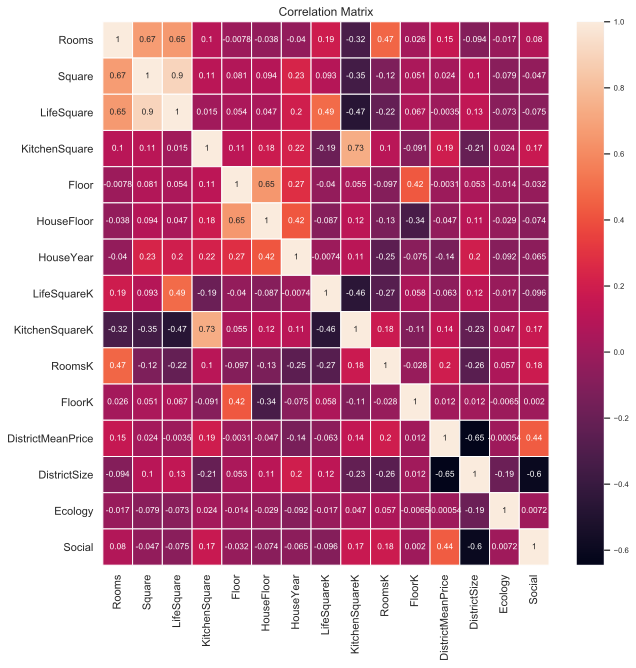

In [66]:
# Матрица корреляций
corr_matrix = X.corr()

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.set(font_scale=0.7)
axes.set_title("Correlation Matrix", fontsize=12)
sns.heatmap(corr_matrix, annot=True, linewidths=1)

In [67]:
# разбиение датасета на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [68]:
# Стандартизация признаков сильного выхлопа не дает
# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)

# X_test_scaled = scaler.fit_transform(X_test)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

## (6) Использование модели GradientBoostingRegressor

In [69]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [70]:
# узнаем какие гиперпараметры дадут наилучший результат (врмея выполнения менее минуты)
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}
gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=42, shuffle=True), n_jobs=-1)
%time gs.fit(X, y)

CPU times: user 2.85 s, sys: 125 ms, total: 2.97 s
Wall time: 45.1 s


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                             

In [71]:
# наилучшие параметры:
gs.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [72]:
# наилучший результат
gs.best_score_

0.7383454544802607

In [73]:
# обучаем модель
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [74]:
# делаем прогноз
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)

Train R2:	0.86
Test R2:	0.71


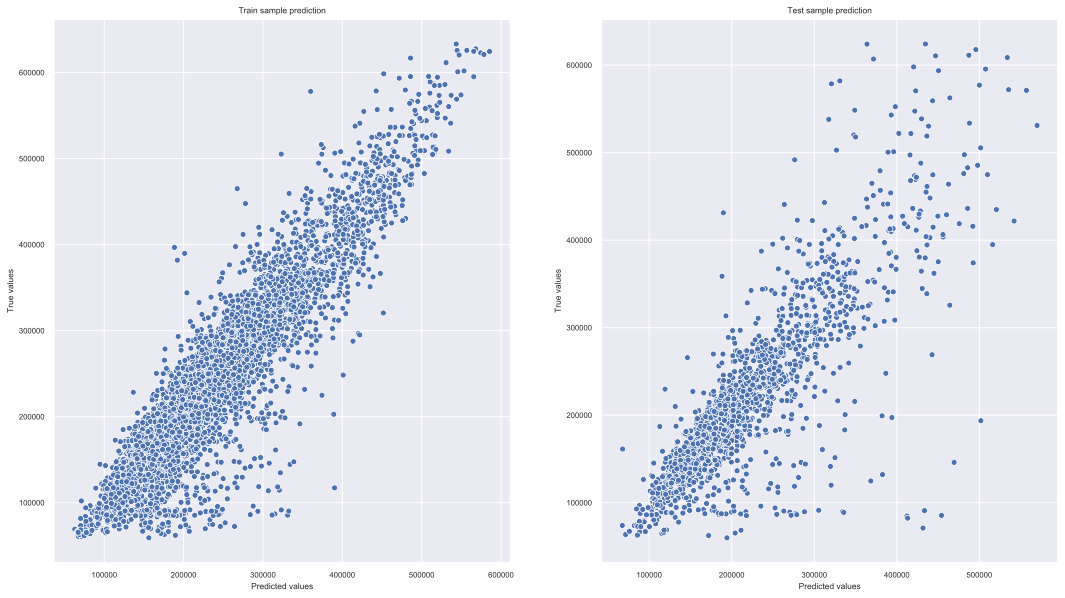

In [75]:
# оцениваем результат
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [76]:
# оцениваем важность признаков
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
11,DistrictMeanPrice,0.339422
1,Square,0.253270
0,Rooms,0.224451
12,DistrictSize,0.029872
14,Social,0.025076
3,KitchenSquare,0.022748
6,HouseYear,0.020950
9,RoomsK,0.015092
2,LifeSquare,0.013263
5,HouseFloor,0.012961


## (7) Прогнозируем в тестовом датасете

In [77]:
# построение прогноза на тестовом датасете
test_preds = gb_model.predict(df_test[feature_names])
test_preds

array([158722.76968535, 211918.14954088, 262339.20287501, ...,
       317926.34684384, 194082.37326152, 184864.16738326])

In [78]:
# перезапись np.array в pd.DataFrame с требуемыми колонками
result = pd.DataFrame(test_preds, columns=['Price'])
result = result.reset_index()
result.columns = ['Id', 'Price']
result

,Id,Price
0,0,158722.769685
1,1,211918.149541
2,2,262339.202875
3,3,297962.865622
4,4,131184.679038
...,...,...
4995,4995,230319.480269
4996,4996,134079.664685
4997,4997,317926.346844
4998,4998,194082.373262


In [79]:
# сохранение результатов в соответствии с требованиями
result.to_csv(RESULT_PATH, sep=',', index=False)